# Setup: Import libraries, enable eager execution, and make the runtime aware of remote TPU devices

In [0]:
# TensorFlow and tf.keras
import tensorflow as tf

import os 
import numpy as np

from tensorflow import keras

tf.enable_eager_execution()

# Make the runtime aware of a remote server which has access to TPUs.
tf.contrib.eager.connect_to_remote_host(os.environ['COLAB_TPU_ADDR'])

# The list of available devices

We print all devices that the tensorflow runtime is aware of, and can schedule operations on.


In [2]:
DEVICES = tf.contrib.eager.list_devices()
print("Available devices:")
for i, device in enumerate(DEVICES):
  print("%d) %s" % (i, device))

Available devices:
0) /job:worker/replica:0/task:0/device:CPU:0
1) /job:worker/replica:0/task:0/device:XLA_CPU:0
2) /job:worker/replica:0/task:1/device:CPU:0
3) /job:worker/replica:0/task:1/device:XLA_CPU:0
4) /job:worker/replica:0/task:1/device:XLA_GPU:0
5) /job:worker/replica:0/task:1/device:TPU:0
6) /job:worker/replica:0/task:1/device:TPU:1
7) /job:worker/replica:0/task:1/device:TPU:2
8) /job:worker/replica:0/task:1/device:TPU:3
9) /job:worker/replica:0/task:1/device:TPU:4
10) /job:worker/replica:0/task:1/device:TPU:5
11) /job:worker/replica:0/task:1/device:TPU:6
12) /job:worker/replica:0/task:1/device:TPU:7
13) /job:worker/replica:0/task:1/device:TPU_SYSTEM:0


In [0]:
# Alias important devices, and a few miscellaneous constants

LOCAL_CPU = "/job:worker/replica:0/task:0/device:CPU:0" # Task 0 is always local
REMOTE_CPU = "/job:worker/replica:0/task:1/device:CPU:0" # Task 1 is remote
REMOTE_TPU = "/job:worker/replica:0/task:1/device:TPU:0" # TPU core 0

LABEL_NAMES = ['t_shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']

BATCH_SIZE = 1024
NUM_STEPS = 10

# Download fashion MNIST data

In [0]:
def get_dataset(batch_size):
  """Function that returns a train and test dataset from keras fashion MNIST data."""
  # Get data
  (train_images,
   train_labels), (test_images,
                   test_labels) = keras.datasets.fashion_mnist.load_data()

  # Preprocess
  train_images = train_images / 255.0
  test_images = test_images / 255.0

  # By default this returns float64 for the image dtype (after preprocessing 
  # above), and uint8 for the label. Neither of these
  # dtypes is supported on TPUs, so we cast to the desired type.
  train_images = train_images.astype(np.float32)
  test_images = test_images.astype(np.float32)
  train_labels = train_labels.astype(np.int64)
  test_labels = test_labels.astype(np.int64)

  # Since images are black and white, they are represented as 2D arrays,
  # but Conv2D expects a separate dimension for channels, so add it.
  train_images = np.expand_dims(train_images, -1)
  test_images = np.expand_dims(test_images, -1)

  print("Returning train dataset with %d images, and test dataset with %d images" % (train_images.shape[0], test_images.shape[0]))

  train_dataset = tf.data.Dataset.from_tensor_slices(
      (train_images, train_labels)).shuffle(10000).repeat().batch(batch_size)
  test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_images, test_labels)).shuffle(10000).repeat().batch(batch_size)
  return (train_dataset, test_dataset)

4423680/4422102 [==============================] - 0s 0us/step
Returning train dataset with 60000 images, and test dataset with 10000 images
Some test images and labels:


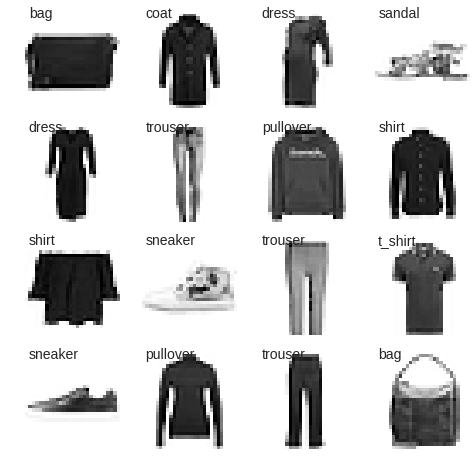

In [5]:
# Download the data to the local CPU, and visualize a few images to make sure things look OK.
train_dataset, test_dataset = get_dataset(batch_size=16)

from matplotlib import pyplot
%matplotlib inline

def plot_predictions(images, predictions):
  n = int(images.shape[0])
  nc = int(np.ceil(n / 4))
  f, axes = pyplot.subplots(nc, 4)
  for i in range(nc * 4):
    if i > n:
      continue

    y = i // 4
    x = i % 4
    axes[x, y].axis('off')
    
    label = LABEL_NAMES[predictions[i]]
    axes[x, y].imshow(images[i].numpy().squeeze())
    axes[x, y].text(0.5, 0.5, label, fontsize=14)

  pyplot.gcf().set_size_inches(8, 8)  

with tf.device(LOCAL_CPU):
  test_it = iter(test_dataset)

print("Some test images and labels:")
plot_predictions(*test_it.next())

# Model definition

In [0]:
def get_model(input_shape=[28, 28, 1]):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.BatchNormalization(input_shape=input_shape))
  model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.BatchNormalization(input_shape=input_shape))
  model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.BatchNormalization(input_shape=input_shape))
  model.add(tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(256))
  model.add(tf.keras.layers.Activation('elu'))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(10))
  model.add(tf.keras.layers.Activation('softmax'))

  model.compile(
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3, ),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['sparse_categorical_accuracy']
  )

  return model

# Running eagerly on the remote CPU device

This demonstrates running ops singly on a remote CPU, or defunning them and running a set of them together.

In [7]:
with tf.device(REMOTE_CPU):
  remote_train_dataset, remote_test_dataset = get_dataset(BATCH_SIZE)

  model = get_model()

  model.fit(remote_train_dataset, steps_per_epoch=NUM_STEPS)

# Defun the model call
with tf.device(REMOTE_CPU):
  model.call = tf.contrib.eager.defun(model.call)

  model.fit(remote_train_dataset, steps_per_epoch=NUM_STEPS)

Returning train dataset with 60000 images, and test dataset with 10000 images
Epoch 1/1
10/10 [==============================] - 17s 2s/step - loss: 3.6720 - sparse_categorical_accuracy: 0.4224
Epoch 1/1
10/10 [==============================] - 17s 2s/step - loss: 2.1227 - sparse_categorical_accuracy: 0.5997


# Training eagerly on a a single TPU core

This trains remotely on a TPU core, instead of the CPU. Notice that the code is __identical__ to above save the device annotation. We up the number of steps a little since training is faster on the TPU.

Defunning model.call allows us to bypass some added TPU overhead which speeds up the computation further.

In [8]:
with tf.device(REMOTE_TPU):
  remote_train_dataset, remote_test_dataset = get_dataset(BATCH_SIZE)

  model = get_model()

  model.fit(remote_train_dataset, steps_per_epoch=NUM_STEPS)

# Defun the model call
with tf.device(REMOTE_TPU):
  model.call = tf.contrib.eager.defun(model.call)

  model.fit(remote_train_dataset, steps_per_epoch=NUM_STEPS)

Returning train dataset with 60000 images, and test dataset with 10000 images
Epoch 1/1
10/10 [==============================] - 14s 1s/step - loss: 2.9853 - sparse_categorical_accuracy: 0.4215
Epoch 1/1
10/10 [==============================] - 4s 354ms/step - loss: 1.1110 - sparse_categorical_accuracy: 0.6377


# Training on the TPU, driving all 8 cores 

We're ready to train. We first construct our model on the TPU, and compile it. Note that we're using the same model that we used above.

Here we demonstrate that we can use a generator function and `fit_generator` to train the model.  You can also pass in `x_train` and `y_train` to `tpu_model.fit()` instead.

Instead of using eager mode, this creates a graph based model (note that the same keras model definition can be used in both eager and graph modes), and executes it as a graph. 

In [9]:
with tf.Graph().as_default():
  (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
  x_train = np.expand_dims(x_train, -1)
  x_test = np.expand_dims(x_test, -1)

  tpu_model = tf.contrib.tpu.keras_to_tpu_model(
      get_model(),
      strategy=tf.contrib.tpu.TPUDistributionStrategy(
          tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
      )
  )
  tpu_model.compile(
      optimizer=tf.train.AdamOptimizer(learning_rate=1e-3, ),
      loss=tf.keras.losses.sparse_categorical_crossentropy,
      metrics=['sparse_categorical_accuracy']
  )

  def train_gen(batch_size):
    while True:
      offset = np.random.randint(0, x_train.shape[0] - batch_size)
      yield x_train[offset:offset+batch_size], y_train[offset:offset + batch_size]
      
  tpu_model.fit_generator(
      train_gen(1024),
      epochs=10,
      steps_per_epoch=NUM_STEPS*10,
      validation_data=(x_test, y_test),
  )

INFO:tensorflow:Querying Tensorflow master (b'grpc://10.94.182.98:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 13786388346594174033)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 17542506126884251846)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 11636637250159123212)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 17796995217707805584)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 16858961831205942326)
INFO:tensorflow:*** Available Device: _Dev